# Nonlinear Static Estimation
Investigates the nonlinear estimation problem for a ship lost at sea given ranging from a group of beacons on the shore (located at $x=0$) 

* See setup and pictures on 13-5
* Picture shown below - beacon 0 at the origin - location of other 2 beacons known
* Originally use Beacons 0 and 1
* Range meaurements are nonlinear 

In [1]:
%load_ext autoreload
%autoreload 2
%run basic_material

import random, sys, copy
from numpy.random import randn
import scipy.linalg
from scipy.linalg import expm, sqrtm

import scipy.optimize
import sympy as sym
from scipy.optimize import minimize

from sympy import Matrix, init_printing
init_printing()

d2r = np.pi/180
Low_Noise = False

Running Python: 3.8.16


## Initial Conditions and Measurements

In [2]:
#actual (unknown) solution
x = np.array([[-3], [0]])

# initial uncertainty in location
Q0 = np.array([[0.2**2, 0], [0, 0.3**2]]) # initial state uncertainty

# initially start at xb within +/-1sigma of the actual 
xb = x + sqrtm(Q0)@np.vstack(randn(2)) # initial state used in the opt
xb = np.vstack(np.array([[-3.3], [0.2]])) # interesting problem to solve

if 0:
    L = 4 # +ve taken to be in the negative x_2 direction
    L2 = -2 # location of second measurement
else: # reverse order of meas
    L = -2 
    L2 = 4 
    
TOL = 1e-11 # solution tolerance
rr_max = 12 # max number of iterations

# sensing noise
if Low_Noise:
    V = (0.4*d2r)**2 # measurement noise
else:
    V = (0.7*d2r)**2 # measurement noise

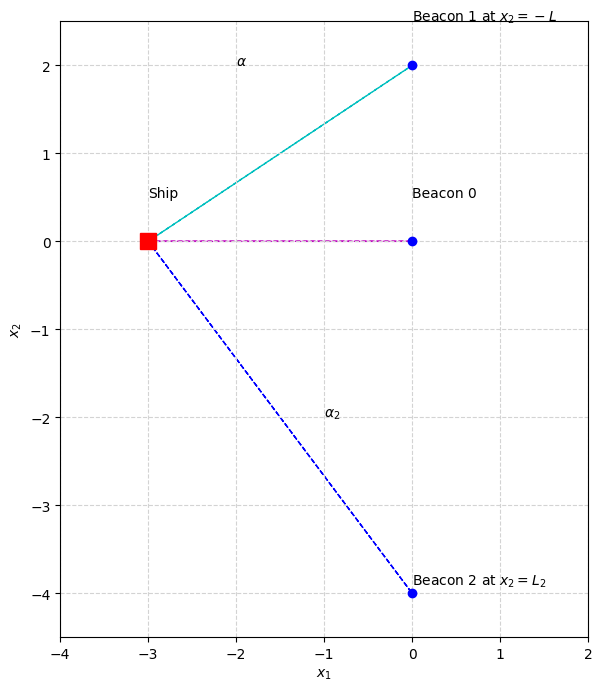

In [3]:
plt.figure(1,figsize=(8,8))
plt.grid(color='lightgray',linestyle='--')
plt.plot(x[0],x[1],'rs',ms=12)
plt.plot(0,0,'bo')
plt.plot(0,-L,'bo')
plt.plot(0,-L2,'bo')
plt.text(x[0],x[1]+.5,'Ship')
plt.text(0,0+.5,'Beacon 0')
plt.text(0,-L+.5,'Beacon 1 at $x_2=-L$')
plt.text(0,-L2+.1,'Beacon 2 at $x_2=L_2$')
plt.text(-2,-L/2+1,r'$\alpha$')
plt.text(-1,-L2/2,r'$\alpha_2$')
plt.arrow(0,-L,x[0,0],L,lw=1,ls='--',color='c')
plt.arrow(0,-L2,x[0,0],L2,lw=1,ls='--',color='b')
plt.arrow(0,0,x[0,0],x[1,0],lw=1,ls='--',color='m')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.axis('square')
plt.ylim(-4.5,2.5)
plt.xlim(-4,2)
plt.savefig("figs/NL_ex1_1.png")
plt.show()

In [4]:
# for plotting an uncertainty ellipse
def plot_ellipse(xe,QI): # for showing the progress
    t_max = 100
    t = np.linspace(0, 2*np.pi, t_max)
    a = QI[0,0]
    b = QI[0,1]
    c = QI[1,1]
    lam1 = np.sqrt((a+c)/2+np.sqrt(((a-c)/2)**2+b**2))
    lam2 = np.sqrt((a+c)/2-np.sqrt(((a-c)/2)**2+b**2))

    if ((b==0) & (a >= c)):
        phi = 0
    elif ((b == 0) & (a < c)):
        phi = np.pi/2
    else:
        phi = np.arctan2(lam1**2-a,b)

    Ellipse_xh = np.zeros((t_max,2))
    Ellipse_xh[:,0] = np.ones((1,t_max))*xe[0,0]+lam1*np.cos(t)*np.cos(phi)-lam2*np.sin(t)*np.sin(phi)
    Ellipse_xh[:,1] = np.ones((1,t_max))*xe[1,0]+lam1*np.cos(t)*np.sin(phi)+lam2*np.sin(t)*np.cos(phi)
    return Ellipse_xh

def Circle_of_constant_alpha(xc,L): # circle of constant alpha to show the direction **not** measured in
    t_max = 100;
    t = np.linspace(0, 2*np.pi, t_max)
    circ = np.zeros((t_max,2))
    Radius = np.sqrt(xc[0,0]**2+L**2)/2
    circ[:,0] = np.ones((1,t_max))*xc[0,0]/2 + Radius*np.cos(t)
    circ[:,1] = -np.ones((1,t_max))*L/2 + Radius*np.sin(t)
    return circ

circ = Circle_of_constant_alpha(x,L)
circ2 = Circle_of_constant_alpha(x,L2)

In [5]:
# define geometry of problem and 
# measurements, which are the angles between the 2 beacons 
x1,x2,sL = sym.symbols('x1 x2 sL')
r1sq = x1**2 + x2**2
r2sq = x1**2+(x2+sL)**2
fun = sym.acos((sL**2-r1sq-r2sq)/(-2*sym.sqrt(r1sq*r2sq)))
numfun=sym.lambdify([x1,x2,sL],fun) # measurement equation
gradfun=[sym.diff(fun,var) for var in (x1,x2)] #take the gradient symbolically wrt x
numgradfun=sym.lambdify([x1,x2,sL],gradfun) #turn into a bivariate lambda for numpy

def Measurement(xm,L):
    return numfun(xm[0,0],xm[1,0],L)

# Actual measurements
z_act_1 = Measurement(x,L) # beacons 0 and 1
z_act_2 = Measurement(x,L2) # beacons 0 and 2

# add random noise scaled by V
z =  z_act_1 + np.sqrt(V)*randn(1) # measured angle (note the sqrt here)
z2 = z_act_1 + np.sqrt(V)*randn(1) # second measurement of first angle 
z3 = z_act_2 + np.sqrt(V)*randn(1) # second measured angle (note the sqrt here)
z4 = z_act_2 + np.sqrt(V)*randn(1) # second measurement of second angle 

print(f'Actual state x: ',x.T[0])
print(f'Initial belief: ',xb.T[0])
print('\nActual First Alpha: ' + str(round(z_act_1/d2r,2)),'degs')
print('Meas First Alpha: ' + str(round(z[0]/d2r,2)), 'degs')
print('\nActual Second Alpha: ' + str(round(z_act_2/d2r,2)),'degs')
print('Meas Second Alpha: ' + str(round(z3[0]/d2r,2)), 'degs')

Actual state x:  [-3  0]
Initial belief:  [-3.3000  0.2000]

Actual First Alpha: 33.69 degs
Meas First Alpha: 32.53 degs

Actual Second Alpha: 53.13 degs
Meas Second Alpha: 52.77 degs


In [6]:
def nllsfit(x0,Q0,xk,Qk,z,R,L):  # see 12-4 for equations
    zk = Measurement(xk,L) # measurement would get at current estimate xk 
    H = np.asmatrix(numgradfun(xk[0,0],xk[1,0],L)) # linearized meas matrix
    Qkp1 = np.linalg.inv(np.linalg.inv(Q0) + H.T@np.linalg.inv(np.atleast_2d(R))@H) 
    xkp1 = x0 + Qkp1@H.T*(z - zk - H@(x0 - xk))/R
    zkp1 = Measurement(xkp1,L) # measurement would get at current estimate xk 
    GR = np.linalg.inv(Q0)@(xkp1 - x0) - H.T*(z - zkp1)/R
    return  xkp1, Qkp1, GR

In [7]:
def iterated_solution(x0,Q0,z,V,L):
    # iterated solution
    xh = copy.deepcopy(x0) # temporary solution
    Qh = copy.deepcopy(Q0) # temporary solution
    GR = 1 
    iter_count = 0 #limit on the # of iterations
    X = np.zeros((rr_max+1,3))   # storage
    while ((np.linalg.norm(GR) > TOL) & (iter_count < rr_max)):
        X[iter_count][0:2] = xh.T  
        X[iter_count][2] = iter_count
        xh,Qh,GR = nllsfit(x0,Q0,xh,Qh,z,V,L)
        iter_count += 1
    else:
        X[iter_count][0:2] = x.T  # put actual answer as last value for plotting reasons
        X[iter_count][2] = iter_count

    print(f'Resulting Covariance from this measurement')
    display(Matrix(np.round(Qh,6)))
    print(f'Resulting Gradient from this measurement {np.linalg.norm(GR):.3e}')
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    fig.tight_layout(pad=1.0)
    ax1.plot(X[0:iter_count,2],X[0:iter_count,0],'rs-',label=r'$\hat x_1$')
    ax1.plot(X[iter_count,2],X[iter_count,0],'k*',label=r'$x_1^{act}$')
    ax1.legend(loc='best')
    ax1.set(xlabel='Count', ylabel='Solution',title='Solution path with actual')
    ax2.plot(X[0:iter_count,2],X[0:iter_count,1],'bd-',label=r'$\hat x_2$')
    ax2.plot(X[iter_count,2],X[iter_count,1],'k*',label=r'$\hat x^{act}_2$')
    ax2.legend(loc='best')
    ax2.set(xlabel='Count')
    
    plt.figure(fignum,figsize=(12,6))
    plt.grid(color='lightgray',linestyle='--')
    plt.plot(x[0,0],x[1,0],'rs',label=r'$x$')
    plt.plot(np.array([0, x[0,0]]),np.array([0, x[1,0]]),'m--')
    plt.plot(np.array([0, x[0,0]]),np.array([-L, x[1,0]]),'c--')
    plt.plot(circ[:,0],circ[:,1],'b:')
    if (L < 0): # second meas has negative L value
        plt.plot(np.array([0, x[0,0]]),np.array([-L2, x[1,0]]),'c--')
        plt.plot(circ2[:,0],circ2[:,1],'r:')
       
    Ellipse_x0 = plot_ellipse(x0,2*Q0)
    plt.plot(Ellipse_x0[:,0],Ellipse_x0[:,1],'k:')
    plt.plot(x0[0,0],x0[1,0],'ks',label=r'$\hat x^-$')

    Ellipse_xh = plot_ellipse(xh,2*Qh)
    plt.plot(Ellipse_xh[:,0],Ellipse_xh[:,1],'g--')
    plt.plot(xh[0,0],xh[1,0],'gd',label=r'$\hat x^+$')
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.axis('square')
    plt.xlim(x[0]-0.5,x[0]+0.5)
    plt.ylim(x[1]-0.5,x[1]+0.5)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.tight_layout()
    plt.savefig("figs/NL_ex1_"+str(fignum)+".png")
    plt.show()
    return xh, Qh, Ellipse_xh 

## First measurement of First type

Resulting Covariance from this measurement


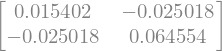

Resulting Gradient from this measurement 5.347e-13


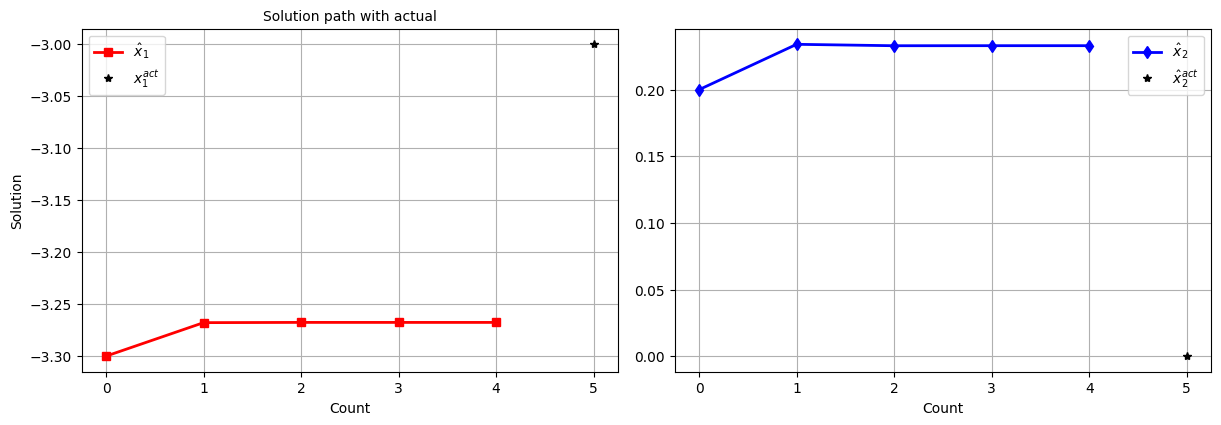

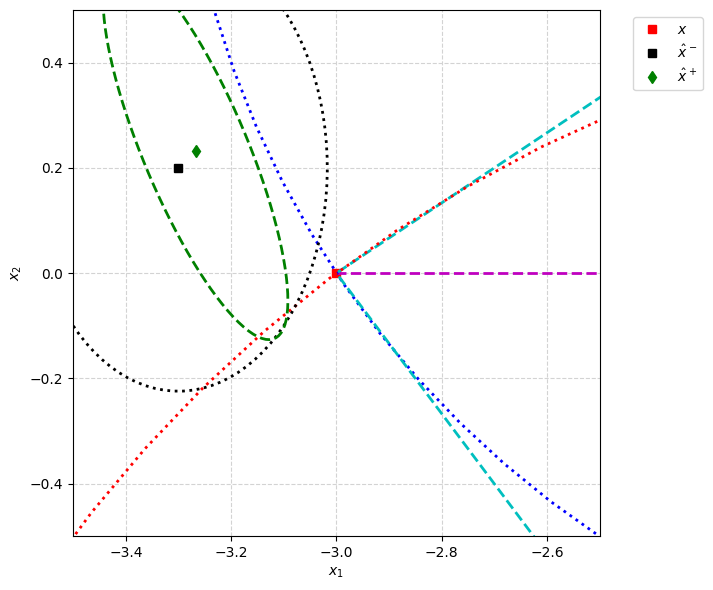

1) First measurement improves estimate
2) Large uncertainty remains aligned with circle of constant angle


In [8]:
fignum = 3
xh, Qh, Ellipse_xh = iterated_solution(xb,Q0,z,V,L)
print('1) First measurement improves estimate')
print('2) Large uncertainty remains aligned with circle of constant angle')

## Second measurement of First type

Resulting Covariance from this measurement


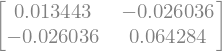

Resulting Gradient from this measurement 2.956e-07


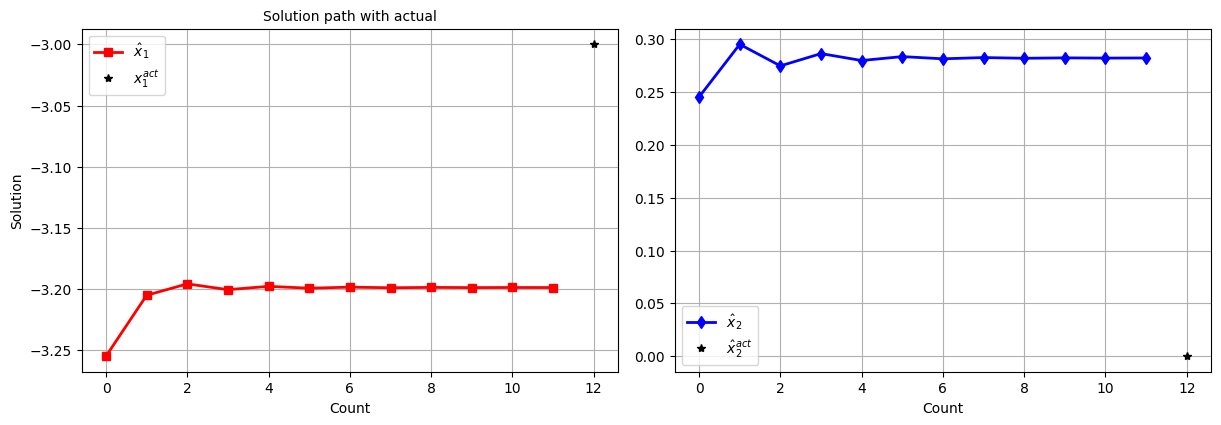

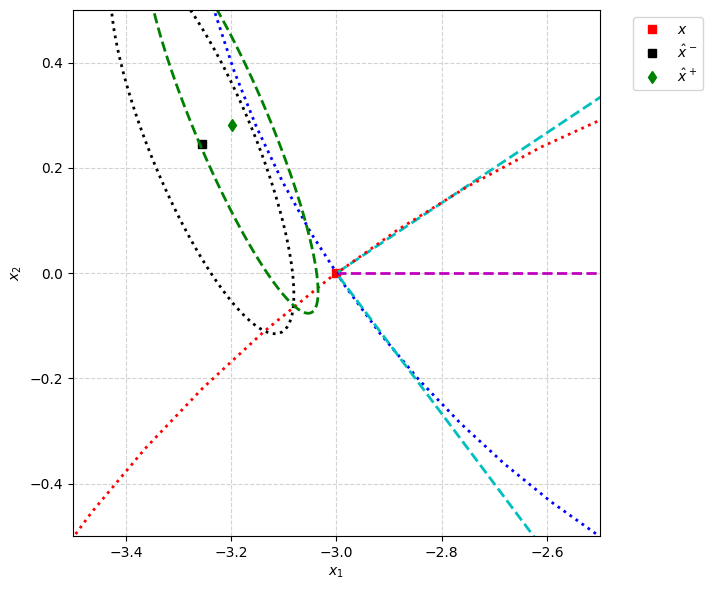

1) First measurement improves estimate
2) Large uncertainty remains aligned with circle of constant angle
3) Repeating same measurement leads to only incremental improvements


In [13]:
fignum = 4
xh2, Qh2, Ellipse_xh2 = iterated_solution(xh,Qh,z2,V,L)
print('1) First measurement improves estimate')
print('2) Large uncertainty remains aligned with circle of constant angle')
print('3) Repeating same measurement leads to only incremental improvements')

## First measurement of Second type

Resulting Covariance from this measurement


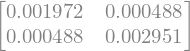

Resulting Gradient from this measurement 2.898e-13


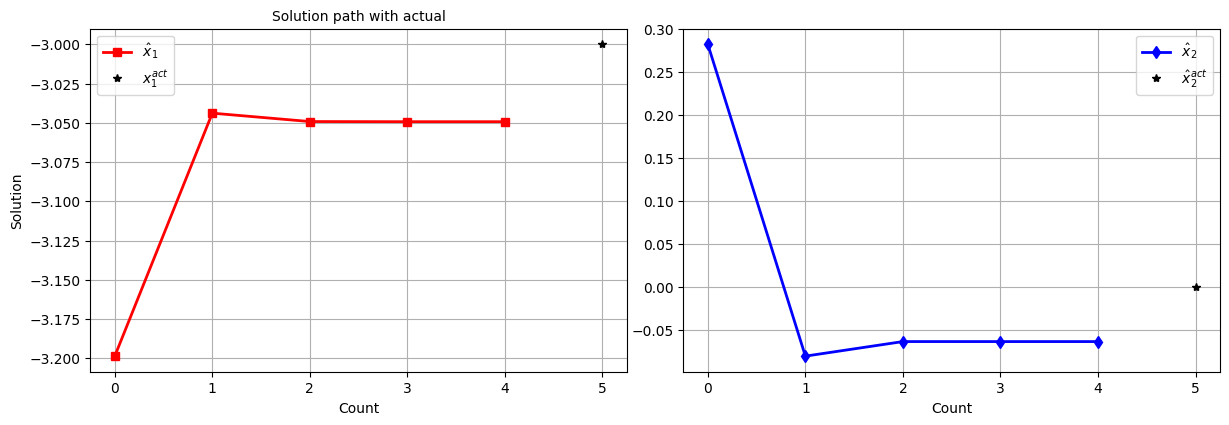

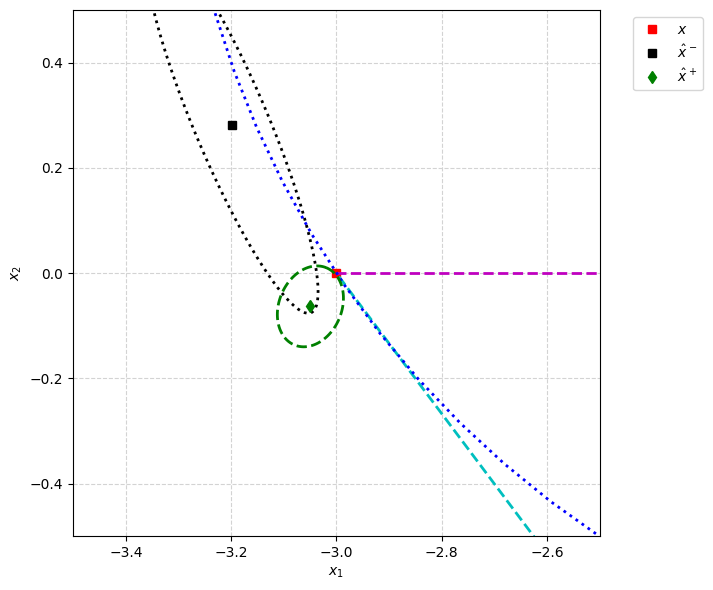

1) First measurement improves estimate
2) Large uncertainty remains aligned with circle of constant angle
3) Repeating same measurement leads to only incremental improvements
4) New measurement geometry yields large improvements


In [14]:
fignum = 5
xh3, Qh3, Ellipse_xh3 = iterated_solution(xh2,Qh2,z3,V,L2)
print('1) First measurement improves estimate')
print('2) Large uncertainty remains aligned with circle of constant angle')
print('3) Repeating same measurement leads to only incremental improvements')
print('4) New measurement geometry yields large improvements')

## Second measurement of Second type

Resulting Covariance from this measurement


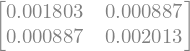

Resulting Gradient from this measurement 4.589e-14


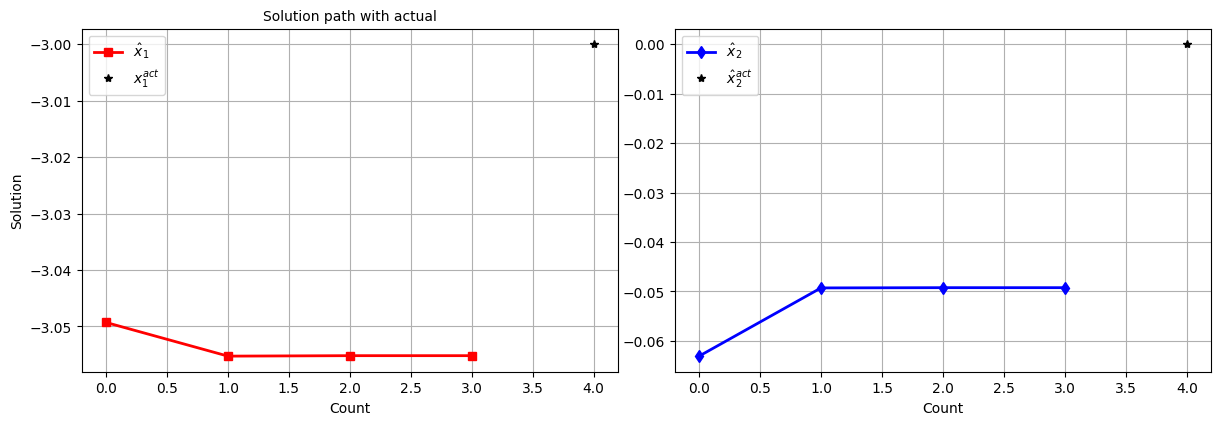

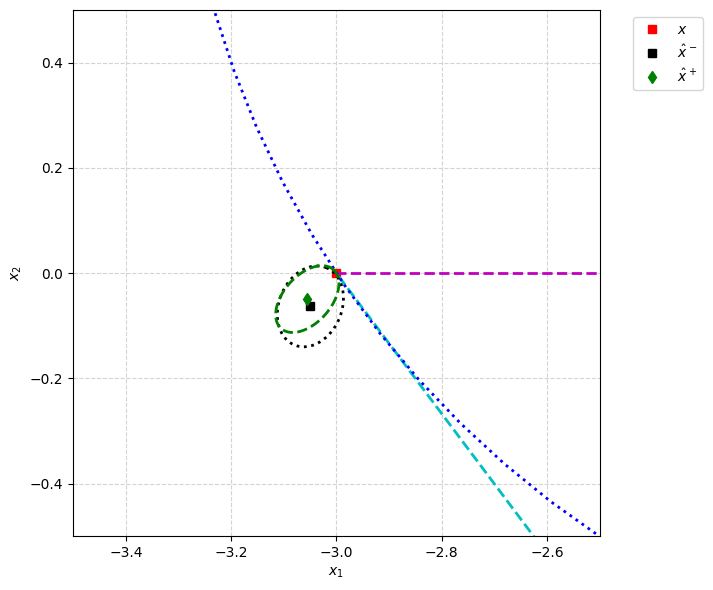

1) First measurement improves estimate
2) Large uncertainty remains aligned with circle of constant angle
3) Repeating same measurement leads to only incremental improvements
4) New measurement geometry yields large improvements
5) Repeating new measurement geometry yields some improvements


In [15]:
fignum = 6
xh4, Qh4, Ellipse_xh4 = iterated_solution(xh3,Qh3,z4,V,L2)
print('1) First measurement improves estimate')
print('2) Large uncertainty remains aligned with circle of constant angle')
print('3) Repeating same measurement leads to only incremental improvements')
print('4) New measurement geometry yields large improvements')
print('5) Repeating new measurement geometry yields some improvements')

## Optimized results

In [17]:
# Now look for the optimal solution
# form cost on 10-2 and optimize it
def func_NLS(xh, Q0, x0, z, L, V):   #x0,Q0,xk,Qk,z,R,L
    xt = xh.reshape(2, 1) - x0
    J1 = xt.T@np.linalg.inv(Q0)@xt
    if (np.size(z) < 2):
        zt = z - np.matrix([Measurement(xh.reshape(2, 1),L)])
    else:
        zt = z - np.matrix([Measurement(xh.reshape(2, 1),L[0]), Measurement(xh.reshape(2, 1),L[1])]).T
    J2 = np.dot(zt.T,zt)/V
    return J1.item() + J2.item()

In [18]:
# optimized results
kk = minimize(func_NLS, xb[:,0].T, args=(Q0, xb, z, L, V))  # first meas
Lboth = np.array([L, L2])
zboth = np.matrix([z, z3])
kk2 = minimize(func_NLS, xb[:,0].T, args=(Q0, xb, zboth, Lboth, V))  # two meas, but V same for both
print(f'Optimal from 1 measurement ',kk.x)
print(f'Optimal from 2 measurement ',kk2.x)

Optimal from 1 measurement  [-3.2547  0.2454]
Optimal from 2 measurement  [-3.0737 -0.0811]


## Comparison plot

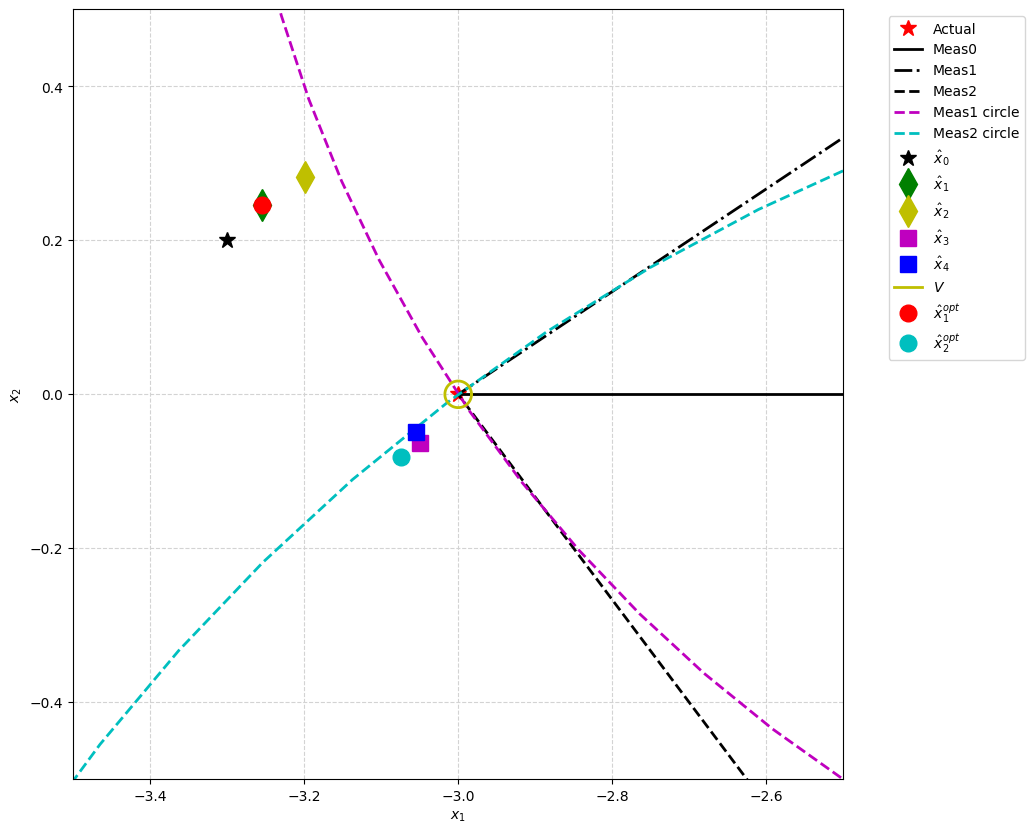

In [20]:
# Compare results
fignum = 7
fig = plt.figure(fignum,figsize=(10,10))
plt.plot(x[0,0],x[1,0],'r*',label=r'Actual',ms=12)
plt.grid(color='lightgray',linestyle='--')

plt.plot(np.array([0, x[0,0]]),np.array([0, x[1,0]]),'k-',label=r'Meas0')
plt.plot(np.array([0, x[0,0]]),np.array([-L, x[1,0]]),'k-.',label=r'Meas1')
plt.plot(np.array([0, x[0,0]]),np.array([-L2, x[1,0]]),'k--',label=r'Meas2')
plt.plot(circ[:,0],circ[:,1],'m--',label=r'Meas1 circle')
plt.plot(circ2[:,0],circ2[:,1],'c--',label=r'Meas2 circle')

plt.plot(xb[0,0],xb[1,0],'k*',label=r'$\hat x_0$',ms=12)
plt.plot(xh[0,0],xh[1,0],'gd',label=r'$\hat x_1$',ms=16)
plt.plot(xh2[0,0],xh2[1,0],'yd',label=r'$\hat x_2$',ms=16)
plt.plot(xh3[0,0],xh3[1,0],'ms',label=r'$\hat x_3$',ms=12)
plt.plot(xh4[0,0],xh4[1,0],'bs',label=r'$\hat x_4$',ms=12)

Ellipse_V = plot_ellipse(x,2*V*np.eye(2))
plt.plot(Ellipse_V[:,0],Ellipse_V[:,1],'y-',label=r'$V$')

plt.plot(kk.x[0],kk.x[1],'ro',label=r'$\hat x_1^{opt}$',ms=12)
plt.plot(kk2.x[0],kk2.x[1],'co',ms=12,label=r'$\hat x_2^{opt}$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.axis('square')
plt.xlim(x[0]-0.5,x[0]+0.5)
plt.ylim(x[1]-0.5,x[1]+0.5)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
fig.savefig("figs/NL_ex1_"+str(fignum)+".png")
plt.show()